In [254]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [266]:
df = pd.read_csv('station1.csv')
df.head()

,date,weekday,e5gas,rotterdam,brent,wti,eurusd,vehicles,station,global_mean,state_mean
0,2014-05-16,5,1.537824,0.622837,109.424042,101.258553,1.369886,13870.0,1,1.546131,1.549588
1,2014-05-17,6,1.541500,0.622486,109.699997,101.669998,1.369580,10676.0,1,1.560708,1.568006
2,2014-05-18,0,1.539000,0.622136,109.699997,101.669998,1.369580,7254.0,1,1.564237,1.571078
3,2014-05-19,1,1.534000,0.621785,109.838928,102.008537,1.370161,13422.0,1,1.563935,1.567407
4,2014-05-20,2,1.554417,0.620475,109.522926,102.058907,1.368282,13057.0,1,1.566228,1.572355


In [267]:
df.shape

(575, 11)

In [268]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df['e5gas'].fillna(0, inplace=True)
df.drop('station', axis=1, inplace=True)
cols = list(df)
cols.insert(0, cols.pop(cols.index('e5gas')))
df = df.loc[:, cols]
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[10, 11, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.847508   0.833333   0.837361   0.930292   0.921895   0.999172   
2   0.858375   1.000000   0.836386   0.933953   0.927822   0.998255   
3   0.850986   0.000000   0.835411   0.933953   0.927822   0.998255   
4   0.836207   0.166667   0.834437   0.935795   0.932700   1.000000   
5   0.896552   0.333333   0.830794   0.931604   0.933425   0.994358   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.914701   0.837500   0.820992  0.858375  
2   0.610974   0.879542   0.873002  0.850986  
3   0.285565   0.889721   0.881676  0.836207  
4   0.872100   0.888849   0.871310  0.896552  
5   0.837391   0.895463   0.885281  0.896552  


In [269]:
# split into train and test sets
values = reframed.values
n_train_days = int(575*.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(460, 1, 9) (460,) (114, 1, 9) (114,)


Train on 460 samples, validate on 114 samples
Epoch 1/50
 - 1s - loss: 0.4873 - val_loss: 0.0738
Epoch 2/50
 - 0s - loss: 0.3957 - val_loss: 0.0445
Epoch 3/50
 - 0s - loss: 0.3098 - val_loss: 0.0580
Epoch 4/50
 - 0s - loss: 0.2269 - val_loss: 0.1004
Epoch 5/50
 - 0s - loss: 0.1496 - val_loss: 0.1513
Epoch 6/50
 - 0s - loss: 0.0895 - val_loss: 0.1960
Epoch 7/50
 - 0s - loss: 0.0782 - val_loss: 0.2013
Epoch 8/50
 - 0s - loss: 0.0775 - val_loss: 0.1778
Epoch 9/50
 - 0s - loss: 0.0685 - val_loss: 0.1632
Epoch 10/50
 - 0s - loss: 0.0673 - val_loss: 0.1638
Epoch 11/50
 - 0s - loss: 0.0627 - val_loss: 0.1636
Epoch 12/50
 - 0s - loss: 0.0617 - val_loss: 0.1538
Epoch 13/50
 - 0s - loss: 0.0591 - val_loss: 0.1462
Epoch 14/50
 - 0s - loss: 0.0563 - val_loss: 0.1455
Epoch 15/50
 - 0s - loss: 0.0553 - val_loss: 0.1409
Epoch 16/50
 - 0s - loss: 0.0536 - val_loss: 0.1356
Epoch 17/50
 - 0s - loss: 0.0510 - val_loss: 0.1339
Epoch 18/50
 - 0s - loss: 0.0496 - val_loss: 0.1305
Epoch 19/50
 - 0s - loss: 0

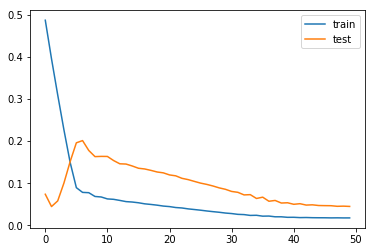

In [270]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [271]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.017


In [272]:
df.head()

,e5gas,weekday,rotterdam,brent,wti,eurusd,vehicles,global_mean,state_mean
date,,,,,,,,,
2014-05-16,1.537824,5,0.622837,109.424042,101.258553,1.369886,13870.0,1.546131,1.549588
2014-05-17,1.541500,6,0.622486,109.699997,101.669998,1.369580,10676.0,1.560708,1.568006
2014-05-18,1.539000,0,0.622136,109.699997,101.669998,1.369580,7254.0,1.564237,1.571078
2014-05-19,1.534000,1,0.621785,109.838928,102.008537,1.370161,13422.0,1.563935,1.567407
2014-05-20,1.554417,2,0.620475,109.522926,102.058907,1.368282,13057.0,1.566228,1.572355


In [292]:
rmse = pd.read_csv('rmse_dict.csv', sep=' ', header=None, names=['index', 'rmse'])

In [294]:
rmse['rmse'].mean()

0.020826238427946203

In [293]:
rmse.shape

(383, 2)

In [297]:
df['e5gas'].std()

0.10150437522803583